# Imports

In [323]:
from stable_baselines3 import A2C,PPO
from tetris_gym.envs.tetris_gym import TetrisGym
from tetris_gym.wrappers.observation import ExtendedObservationWrapper
from tetris_gym.utils.eval_utils import evaluate, create_videos
from agent import agent
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import gym
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import math
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [324]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [325]:
Transition = namedtuple('Transition',
                        ('state', 'action1','action2', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Env

In [326]:
env = TetrisGym(width=10, height=20)

In [327]:
env = ExtendedObservationWrapper(env)

In [328]:
class CustomRewardWrapper(gym.Wrapper):
    
    def __init__(self, env):
        super().__init__(env)
    # Felülírjük a környezet beépített step függvényét
    def step(self, action):

        # Meghívjuk az eredeti környezet step függvényét
        obs, reward, done, info = self.env.step(action)

        # Új jutalmat számítunk, minél jobban eldől az inga vagy elmozog a
        # kocsi, annál jobban büntetjük
        line_reward = 10
        hole_reward = 0.003
        bumpiness_reward = 0.005
        height_reward = 0.002
        lines_cleared = self.env.get_state_properties(obs['board'])[0]
        holes = self.env.get_state_properties(obs['board'])[1]
        bumpiness = self.env.get_state_properties(obs['board'])[2]
        height = self.env.get_state_properties(obs['board'])[3]
        reward = ((pow(line_reward*lines_cleared,2))+10
        )

        
        return obs, reward, done, info

In [329]:
env = CustomRewardWrapper(env)

# Net

In [330]:
class DQN(nn.Module):
    def __init__(self, s_size, a1_size, a2_size, h_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)

        self.fch1 = nn.Linear(h_size,h_size)
        self.fch2 = nn.Linear(h_size,h_size)
        self.drop1 = nn.Dropout(0.5)
        self.fch3 = nn.Linear(h_size,h_size)
        self.drop2 = nn.Dropout(0.2)
        self.fc21 = nn.Linear(h_size, h_size/2)
        self.fc22 = nn.Linear(h_size, h_size/2)
        self.fch21 = nn.Linear(h_size/2, a1_size)
        self.fch22 = nn.Linear(h_size/2, a2_size)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fch1(x))
        x = F.relu(self.drop1(self.fch2(x)))
        x = F.relu(self.drop2(self.fch3(x)))
        out1 = F.relu(self.fc21(x))
        out2 = F.relu(self.fc22(x))
        out1 = self.fch21(out1)
        out2 = self.fch22(out2)
        return [F.sigmoid(out1, dim=1),F.sigmoid(out2, dim=1)]
    
    def act(self, state):
        state = torch.from_numpy(np.concatenate([state['board'].flatten(),state['piece']])).float().unsqueeze(0).to(device)
        probs1 = self.forward(state)[0].cpu()
        probs2 = self.forward(state)[1].cpu()
        m1 = Categorical(probs1)
        action1 = m1.sample()
        m2 = Categorical(probs2)
        action2 = m2.sample()
        return (action1.item(),action2.item()),(m1.log_prob(action1),m2.log_prob(action2))
    def predict(self,state):
        action =self.act(state)
        act1,_ = action[0]
        act2,_ = action[1]
        return act1,act2

# Train

In [331]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.97
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.05
LR = 1e-2
# Get number of actions from gym action space
state_size = env.observation_space['board'].shape[0]*env.observation_space['board'].shape[1]
ac1_size = env.action_space[0].n
ac2_size = env.action_space[1].n
# Get the number of state observations
state = env.reset()
n_observations = len(state)

policy_net = DQN(state_size+1, ac1_size,ac2_size,600).to(device)
target_net = DQN(state_size+1, ac1_size,ac2_size,600).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.SGD(policy_net.parameters(), lr=LR)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            r1,r2 = policy_net(state)
            r1 = r1.max(1)[1].view(1, 1)
            r2 = r2.max(1)[1].view(1, 1)
            
            return r1,r2
    else:
        r1 = torch.tensor([[env.action_space.sample()[0]]], device=device, dtype=torch.long)
        r2 = torch.tensor([[env.action_space.sample()[1]]], device=device, dtype=torch.long)
        
        return r1,r2


episode_durations = []

def plot_durations(show_result=False):
    plt.subplot(1, 2, 1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [332]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch1 = torch.cat(batch.action1)
    action_batch2 = torch.cat(batch.action2)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    qst1,qst2 = policy_net(state_batch)
    #Q_s_t =torch.tensor(, dtype=torch.float32, device=device).unsqueeze(0) 
    state_action_values1 = qst1.gather(1, action_batch1)
    state_action_values2 = qst2.gather(1, action_batch2)
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values1 = torch.zeros(BATCH_SIZE, device=device)
    next_state_values2 = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values1[non_final_mask] = target_net(non_final_next_states)[0].max(1)[0]
        next_state_values2[non_final_mask] = target_net(non_final_next_states)[1].max(1)[0]
    # Compute the expected Q values
    expected_state_action_values1 = (next_state_values1 * GAMMA) + reward_batch
    expected_state_action_values2 = (next_state_values2 * GAMMA) + reward_batch
    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values1, expected_state_action_values1.unsqueeze(1))
    loss += criterion(state_action_values2, expected_state_action_values2.unsqueeze(1))
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [333]:
reward_list = []
def plot_rewards(show_result=False):
    plt.subplot(1, 2, 2)
    durations_t = torch.tensor(reward_list, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('reward')
    plt.plot(reward_list)
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    #plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

Complete


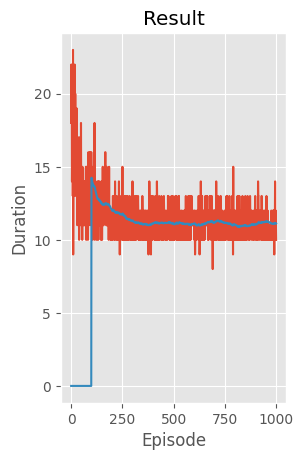

<Figure size 640x480 with 0 Axes>

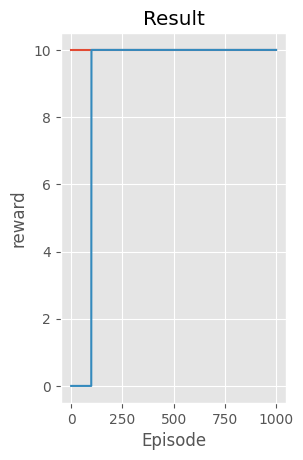

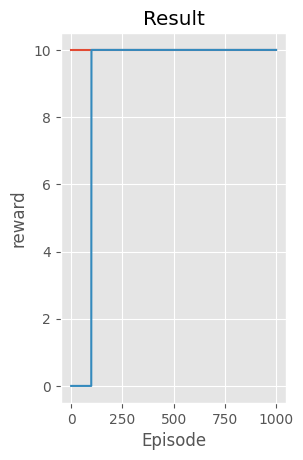

In [334]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 1000

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state = env.reset()
    state = torch.tensor(np.concatenate([state['board'].flatten(),np.array(state['piece']).flatten()],axis=0), dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action1,action2 = select_action(state)
        observation, reward, terminated, _ = env.step((action1.item(),action2.item()))
        reward_orig =reward
        reward = torch.tensor([reward], device=device)
        done = terminated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(np.concatenate([observation['board'].flatten(),np.array(observation['piece']).flatten()],axis=0), dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action1,action2, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
        
        if done:
            episode_durations.append(t + 1)
            reward_list.append(reward_orig)
            #plot_rewards()
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plot_rewards(show_result=True)
plt.ioff()
plt.show()

In [335]:
PATH = "./agent/network.zip"
torch.save(target_net.state_dict(), PATH)


In [336]:
from tetris_gym.utils.eval_utils import create_agent_videos

In [337]:
create_agent_videos(env, target_net)

c:\Users\XY\anaconda3\envs\tetris_gym\lib\site-packages\gym\wrappers\monitor.py:86: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
  logger.warn(


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 0 dimension(s)